In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

In [2]:
cwd= os.getcwd()


In [3]:
os.chdir('/workspace/flower')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/flower'

In [5]:
my_data_dir = 'inputs/leaf-detector/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




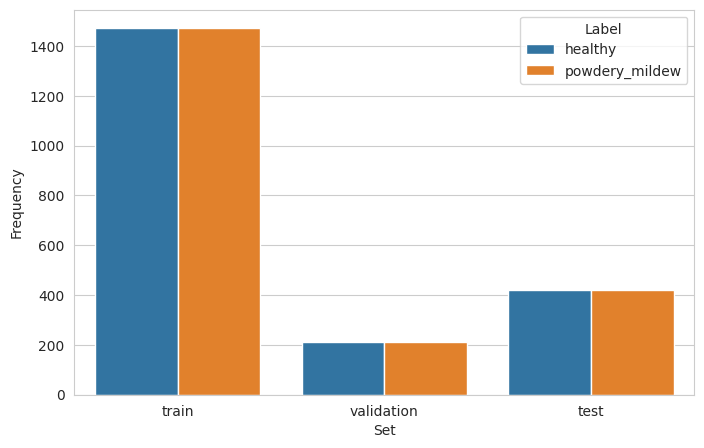

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2024-06-03 13:15:40.660921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [12]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(20, 256, 256, 3)


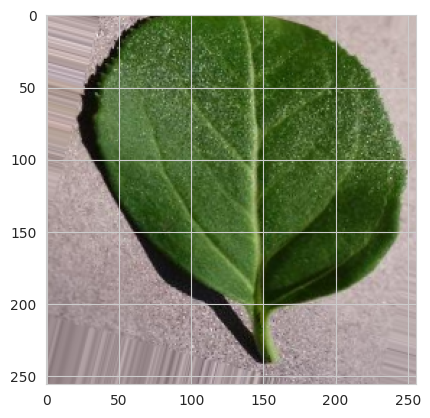

(20, 256, 256, 3)


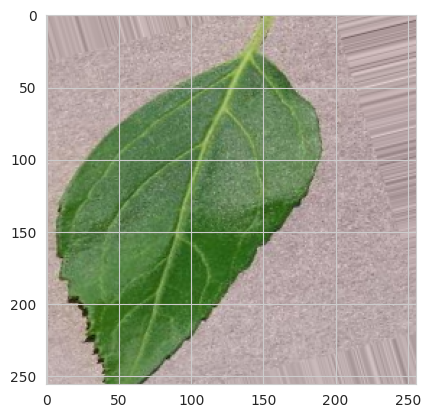

(20, 256, 256, 3)


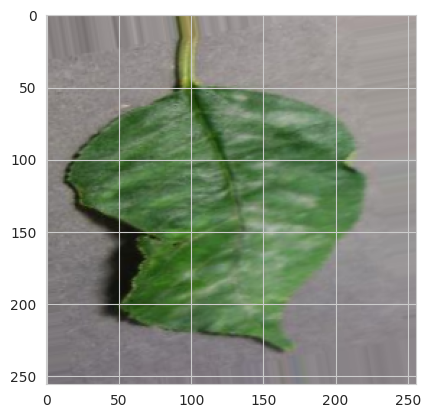

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


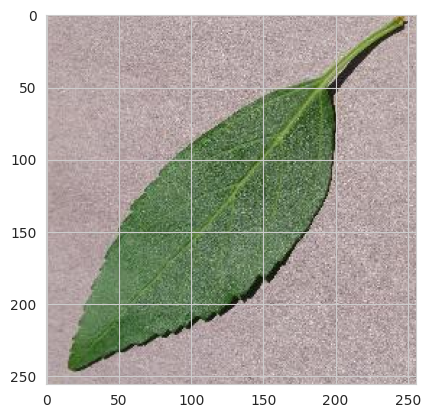

(20, 256, 256, 3)


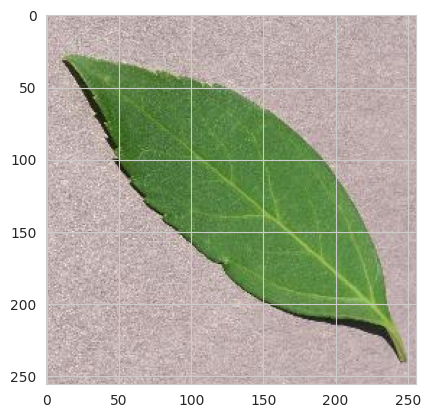

(20, 256, 256, 3)


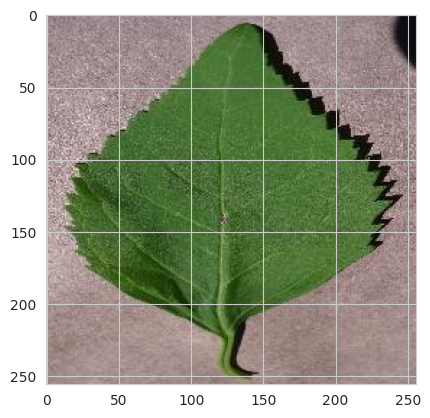

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


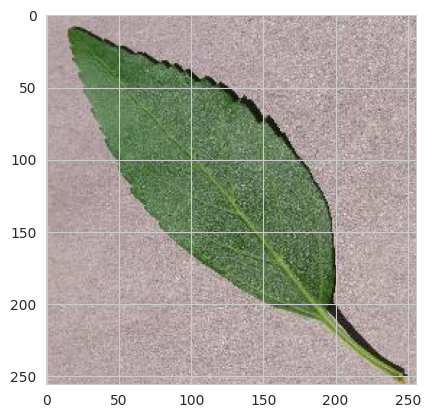

(20, 256, 256, 3)


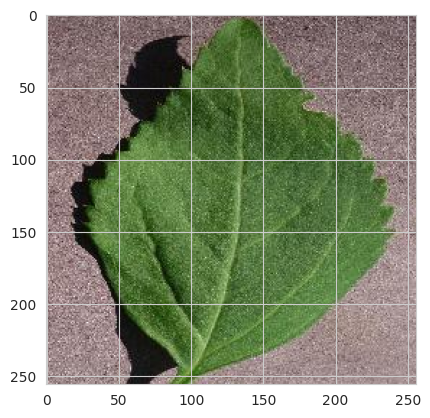

(20, 256, 256, 3)


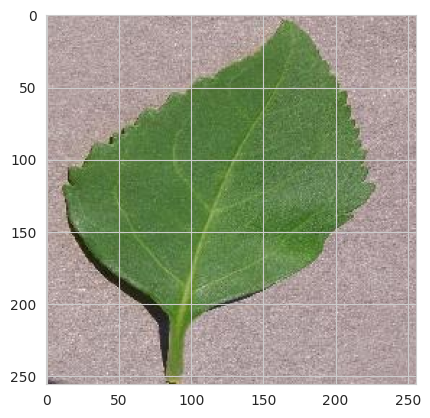

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

## ML model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [21]:
create_tf_model().summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [23]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
147/147 [==============================] - 149s 1s/step - loss: 0.4008 - accuracy: 0.8174 - val_loss: 0.0594 - val_accuracy: 0.9881
Epoch 2/25
147/147 [==============================] - 144s 976ms/step - loss: 0.0800 - accuracy: 0.9726 - val_loss: 0.0306 - val_accuracy: 0.9952
Epoch 3/25
147/147 [==============================] - 163s 1s/step - loss: 0.0257 - accuracy: 0.9925 - val_loss: 0.0161 - val_accuracy: 0.9952
Epoch 4/25
147/147 [==============================] - 251s 2s/step - loss: 0.0274 - accuracy: 0.9935 - val_loss: 0.0220 - val_accuracy: 0.9952
Epoch 5/25
147/147 [==============================] - 229s 2s/step - loss: 0.0069 - accuracy: 0.9976 - val_loss: 0.0043 - val_accuracy: 0.9976
Epoch 6/25
147/147 [==============================] - 206s 1s/step - loss: 0.0415 - accuracy: 0.9887 - val_loss: 0.0102 - val_accuracy: 0.9976
Epoch 7/25
147/147 [==============================] - 188s 1s/step - loss: 0.0105 - accuracy: 0.9976 - val_loss: 0.0037 - val_accuracy: 0.9

In [24]:
model.save('outputs/v1/leaf-detector_model.h5')


/workspace/.pip-modules/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


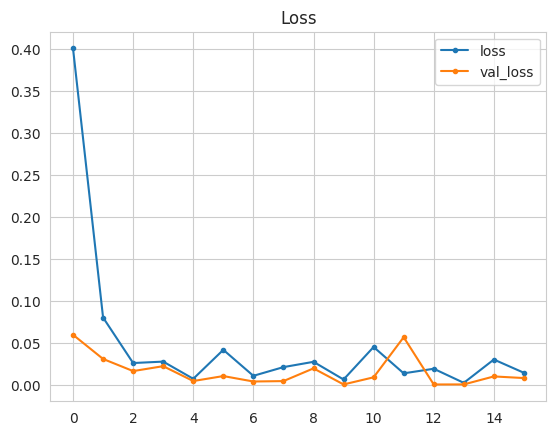

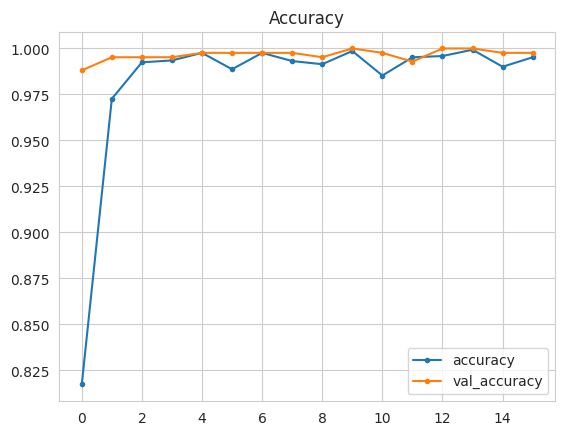

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

In [26]:
from keras.models import load_model
model = load_model('outputs/v1/leaf-detector_model.h5')

In [27]:
evaluation = model.evaluate(test_set)


43/43 [==============================] - 17s 393ms/step - loss: 0.0480 - accuracy: 0.9929


In [28]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

Image shape: (256, 256), Image mode: RGB


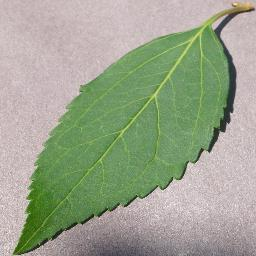

In [29]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [30]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


In [31]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 97ms/step
0.9999999721355479
healthy


In [32]:
!cat .gitignore


core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

In [33]:
!git status


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/Notebook_Template.ipynb
	modified:   requirements.txt

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	inputs/
	jupyter_notebooks/DataVisualization.ipynb
	jupyter_notebooks/Modelling-and-Evaluation.ipynb
	outputs/

no changes added to commit (use "git add" and/or "git commit -a")


In [34]:
!git add .


In [35]:
!git commit -am " Add new plots"


[main 38480a8]  Add new plots
 4221 files changed, 1895 insertions(+), 20 deletions(-)
 create mode 100644 inputs/leaf-detector/cherry-leaves/test/healthy/0048afb8-b950-4c57-9e72-7e26282327ee___JR_HL 9765.JPG
 create mode 100644 inputs/leaf-detector/cherry-leaves/test/healthy/0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4277.JPG
 create mode 100644 inputs/leaf-detector/cherry-leaves/test/healthy/0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4277_flipTB.JPG
 create mode 100644 inputs/leaf-detector/cherry-leaves/test/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165.JPG
 create mode 100644 inputs/leaf-detector/cherry-leaves/test/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165_flipTB.JPG
 create mode 100644 inputs/leaf-detector/cherry-leaves/test/healthy/014161fb-3c15-414b-9af3-00cb51a11d7c___JR_HL 9842_180deg.JPG
 create mode 100644 inputs/leaf-detector/cherry-leaves/test/healthy/04189592-5db7-441e-a831-eaaa2d7f5d21___JR_HL 9867.JPG
 create mode 100644 inputs/leaf-detect

In [36]:
!git push


Enumerating objects: 4242, done.
Counting objects: 100% (4242/4242), done.
Delta compression using up to 16 threads
Compressing objects: 100% (4232/4232), done.
Writing objects: 100% (4238/4238), 128.44 MiB | 14.81 MiB/s, done.
Total 4238 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/leaf-detector_model.h5 is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/Philippos123/flower.git
   a319037..38480a8  main -> main
